In [3]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Warnings
import warnings
warnings.filterwarnings('ignore')


In [14]:
df_2009 = pd.read_excel('datasets/online_retail_II.xlsx', sheet_name='Year 2009-2010', engine='openpyxl')
df_2010 = pd.read_excel('datasets/online_retail_II.xlsx', sheet_name='Year 2010-2011', engine='openpyxl')

# Combine the two DataFrames
df_all = pd.concat([df_2009, df_2010], ignore_index=True)

In [15]:
df_all.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [16]:
# Remove rows with missing Customer ID
df_all = df_all[df_all['Customer ID'].notnull()]

# Remove rows with negative or zero quantity/price
df_all = df_all[(df_all['Quantity'] > 0) & (df_all['Price'] > 0)]

# Create a TotalPrice column
df_all['TotalPrice'] = df_all['Quantity'] * df_all['Price']

# Convert InvoiceDate to datetime
df_all['InvoiceDate'] = pd.to_datetime(df_all['InvoiceDate'])

# Quick check
df_all.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [18]:
# Set snapshot date for Recency calculation
snapshot_date = df_all['InvoiceDate'].max() + pd.Timedelta(days=1)

# Grouping by Customer ID
customer_df = df_all.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'Quantity': 'sum',
    'TotalPrice': ['sum', 'mean']
})

# Rename columns
customer_df.columns = ['Recency', 'Frequency', 'TotalQuantity', 'MonetaryValue', 'AvgOrderValue']
customer_df = customer_df.reset_index()

# Set CLV as MonetaryValue (for now, as a proxy)
customer_df['CLV'] = customer_df['MonetaryValue']

# Check features
customer_df.head()


,Customer ID,Recency,Frequency,TotalQuantity,MonetaryValue,AvgOrderValue,CLV
0,12346.0,326,12,74285,77556.46,2281.072353,77556.46
1,12347.0,2,8,3286,5633.32,22.266087,5633.32
2,12348.0,75,5,2714,2019.40,39.596078,2019.40
3,12349.0,19,4,1624,4428.69,25.306800,4428.69
4,12350.0,310,1,197,334.40,19.670588,334.40


In [19]:
from sklearn.model_selection import train_test_split

# Features and target
X = customer_df[['Recency', 'Frequency', 'TotalQuantity', 'AvgOrderValue']]
y = customer_df['CLV']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 951.25
RMSE: 8195.24


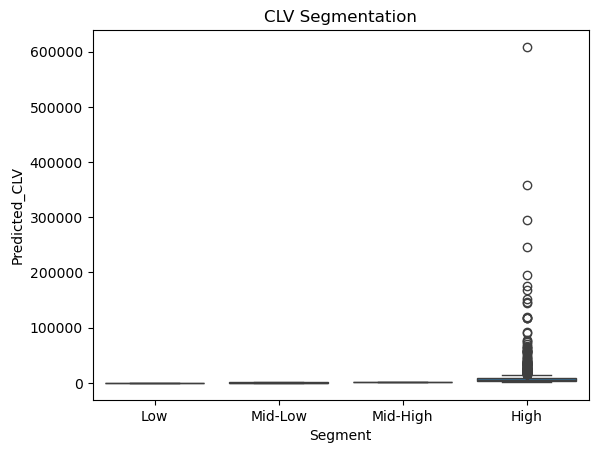

In [23]:
# Predict CLV for all customers
customer_df['Predicted_CLV'] = model.predict(X)

# Segment customers into 4 tiers
customer_df['Segment'] = pd.qcut(customer_df['Predicted_CLV'], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])

# Save output
customer_df.to_csv('predicted_clv.csv', index=False)

# Optional visualization
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Segment', y='Predicted_CLV', data=customer_df)
plt.title('CLV Segmentation')
plt.show()


In [24]:
import joblib

# Save the trained model to a file
joblib.dump(model, 'clv_model.pkl')

print("Model saved as clv_model.pkl")


Model saved as clv_model.pkl


In [25]:
# Load the model from file
loaded_model = joblib.load('clv_model.pkl')

# Example usage
preds = loaded_model.predict(X_test)
